### El objetivo de este proyecto es desarrollar un modelo de predicción que permita estimar el precio de vehículos de segunda mano.  Por consiguiente la variable objetivo es el "Precio".

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import pyspark
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, r2_score

#=======================================================================================
#  Estudio Inicial de Columnas, Nullidad de la Data y Carateristicas de las Variables
#=======================================================================================
def estudo_Nullidad_caracteristicas(datosgenerales):
    columnas_numericas = datosgenerales.select_dtypes(include='number')
    columnas_categoricas = datosgenerales.select_dtypes(include=['object', 'category', 'bool'])
    resumen_numericas = pd.DataFrame({
        'columna': columnas_numericas.columns,
        'tipo': columnas_numericas.dtypes.values,
        'no_nulos': columnas_numericas.notnull().sum().values
    }).sort_values(by='no_nulos', ascending=False)
    resumen_categoricas = pd.DataFrame({
        'columna': columnas_categoricas.columns,
        'tipo': columnas_categoricas.dtypes.values,
        'no_nulos': columnas_categoricas.notnull().sum().values
    }).sort_values(by='no_nulos', ascending=False)
    print("📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):")
    for _, fila in resumen_numericas.iterrows():
        print(f" - {fila['columna']} ({fila['no_nulos']} registros no nulos)")
    print(f"\nTotal columnas numéricas: {len(resumen_numericas)}")
    print("\n🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):")
    for _, fila in resumen_categoricas.iterrows():
        print(f" - {fila['columna']} ({fila['no_nulos']} registros no nulos)")
    print(f"\nTotal columnas categóricas: {len(resumen_categoricas)}")
    print(datosgenerales.shape)

#===============================================================================
#                Cargar Archivos
#===============================================================================
def columnas_con_ceros(df):
    total_filas = len(df)
    conteo_ceros = (df == 0).sum()
    columnas_con_ceros = conteo_ceros[conteo_ceros > 0]
    porcentaje_ceros = (columnas_con_ceros / total_filas * 100).round(2).astype(str) + '%'
    resultado = pd.DataFrame({
        'Total_Ceros': columnas_con_ceros,
        'Porcentaje': porcentaje_ceros    })
    return resultado

#===============================================================================
#                Box Plots 2
#===============================================================================
def box_plots_2(dataframe2,variables):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
    for i, var in enumerate(variables):
        sns.boxplot(ax=axes[i], y=dataframe2[var])  
        axes[i].set_title(f'{var}', fontsize=10)
        axes[i].tick_params(labelsize=8)
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

def box_plots_3(datafarab3,campo_x,campo_y,titulob3):
    top_10_brands = datafarab3[campo_x].value_counts().nlargest(20).index
    plt.figure(figsize=(12, 4))
    sns.boxplot(
        x=campo_x,
        y=campo_y,
        data=datafarab3[datafarab3[campo_x].isin(top_10_brands)],
        order=top_10_brands,
        palette='Spectral'
    )
    plt.xticks(rotation=45)
    plt.title(titulob3)
    plt.show()
#===============================================================================
#        Esta Grafica me permite el histograma de los datos
#===============================================================================
def graficar_histogramas(dataframe, columnas, filas, columnas_por_fila, bins=50):
    total = len(columnas)
    total_subplots = filas * columnas_por_fila
    fig, axes = plt.subplots(filas, columnas_por_fila, figsize=(5 * columnas_por_fila, 4 * filas))
    axes = axes.flatten()
    for i, col in enumerate(columnas):
        sns.histplot(data=dataframe, x=col, ax=axes[i], bins=bins)
        axes[i].set_title(f"Distribución de {col}")
    for j in range(len(columnas), total_subplots):
        fig.delaxes(axes[j]) 
    plt.tight_layout()
    plt.show()
#===============================================================================
#                Detectar Outliners
#===============================================================================
# Detectar outliers usando el método IQR
def Outlineers_IQR(dataframe2, variabless):
    outliers = {}

    for columna in variabless:
        Q1 = dataframe2[columna].quantile(0.25)
        Q3 = dataframe2[columna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.8 * IQR
        outlier_indices = dataframe2[(dataframe2[columna] < lower_bound) | (dataframe2[columna] > upper_bound)].index
        outliers[columna] = len(outlier_indices)
        print(f"'{columna}': {len(outlier_indices)} outliers detectados.  Los cuartiles son: Q1:{Q1} Q3:{Q3} . lower_bound:{lower_bound} upper_bound:{upper_bound} ")
#===============================================================================
#                Esta Grafica me permite el histograma de los datos
#===============================================================================
def graficar_histogramas_autov(dataframe, columnas, bins=50):

    total = len(columnas)
    columnas_por_fila = 2  
    filas = math.ceil(total / columnas_por_fila)

    fig, axes = plt.subplots(filas, columnas_por_fila, figsize=(6 * columnas_por_fila, 4 * filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas):
        sns.histplot(data=dataframe, x=col, ax=axes[i], bins=bins)
        axes[i].set_title(f"Distribución de {col}")
        axes[i].grid(True)
    for j in range(len(columnas), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
#===============================================================================
#                Grafico de Correlaciones
#===============================================================================
def Graf_Corre(dataframec,variablesc, tituloc):
    data_filtrada = dataframec[variablesc]
    plt.figure(figsize=(4, 3))
    sns.heatmap(data_filtrada.corr(), annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
    plt.title(tituloc, fontsize=14)
    plt.show()
#===============================================================================
#                Grafico de Correlaciones Spearman
#===============================================================================
def Prueba_de_Spearman(dataFramSpe,corr_1,corr_2, Texxto):
    from scipy.stats import spearmanr
    df_limpio = dataFramSpe[[corr_1, corr_2]].dropna()
    corr_spearman, _ = spearmanr(df_limpio[corr_1], df_limpio[corr_2])
    print(Texxto, corr_spearman)

In [2]:
#===============================================================================
#                Cargar Archivos
#===============================================================================
Ruta_Arch = "../../vehicles.csv"
total_data= pd.read_csv(Ruta_Arch, sep = ",")

## Exploración inicial de los datos.


### Estudio de las columnas, su tipo y Nulidad de la Data por Columna

In [87]:
estudo_Nullidad_caracteristicas(total_data)

📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):
 - id (426880 registros no nulos)
 - price (426880 registros no nulos)
 - year (425675 registros no nulos)
 - odometer (422480 registros no nulos)
 - lat (420331 registros no nulos)
 - long (420331 registros no nulos)
 - county (0 registros no nulos)

Total columnas numéricas: 7

🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):
 - url (426880 registros no nulos)
 - region (426880 registros no nulos)
 - region_url (426880 registros no nulos)
 - state (426880 registros no nulos)
 - image_url (426812 registros no nulos)
 - posting_date (426812 registros no nulos)
 - description (426810 registros no nulos)
 - transmission (424324 registros no nulos)
 - fuel (423867 registros no nulos)
 - model (421603 registros no nulos)
 - title_status (418638 registros no nulos)
 - manufacturer (409234 registros no nulos)
 - type (334022 registros no nulos)
 - paint_color (296677 registros no nulos)
 - drive (29631

## Resumen de observaciones 1:

- La data está compuesta de **26 columnas**
- El número de registros es **426880**
- **7 columnas** son de datos numéricos
- **19 columnas** son de datos categóricos
- El número de registros Nullos de la columna "country" es **426880**, es decir, todos sus elementos son Nulos, por lo que esta columna esta completamente vacia y será eliminada.
- Tambien sera eliminada la columna id, Latitude y Longitude debido a su granularidad.

In [88]:
total_data2=total_data.copy()
total_data2 = total_data2.drop(columns=['county', 'id', 'lat', 'long'])

#### El siguiente paso fue buscar si existen valores iguales a Cero en las columnas numéricas.  Las columnas 'price', 'odometer' y 'year' no deberian tener valores de cero; ya que no ha Vehiculos gratis,  ni del Año "Cero".  Sin embargo, odometer igual a cero, aunque no es tipico, no podria decirse que sea un dato incorrecto, ya que el vehiculo podria ser Segunda mano y nunca haber sido usado.

In [89]:
print(columnas_con_ceros(total_data2))

          Total_Ceros Porcentaje
price           32895      7.71%
odometer         1965      0.46%


####  Estudo de las Variables numéricas (Histogramas y BoxPlot Exploratorios)

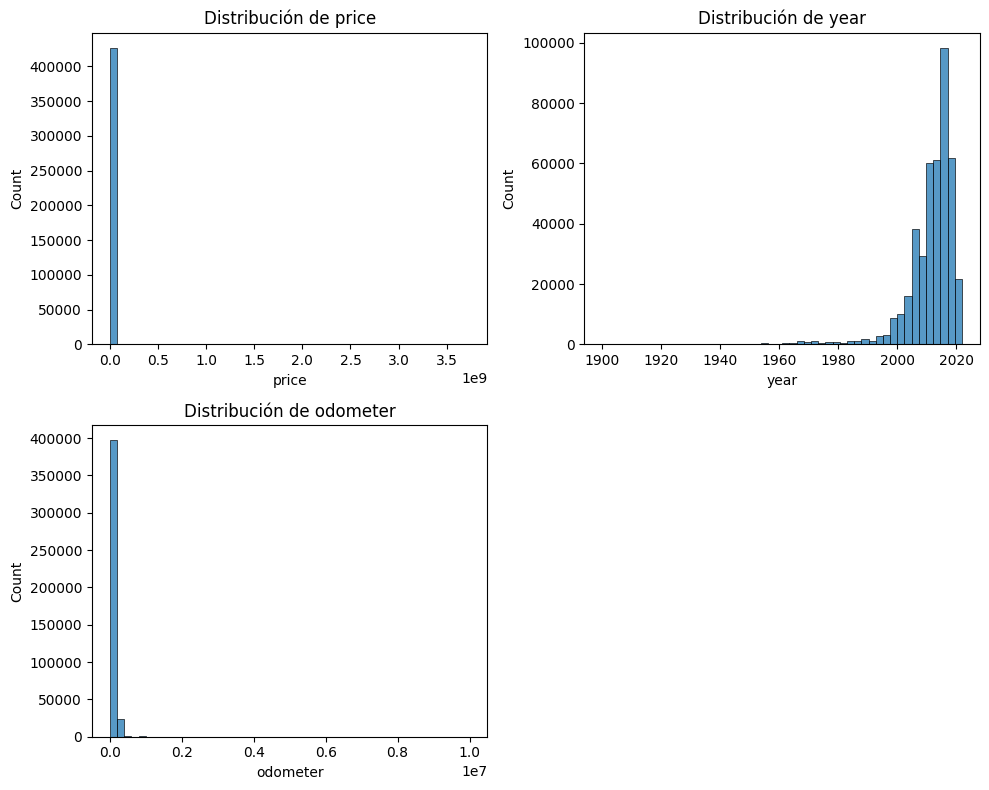

In [90]:
variables_numericas=['price', 'year', 'odometer']
graficar_histogramas(total_data2, variables_numericas,2,2)

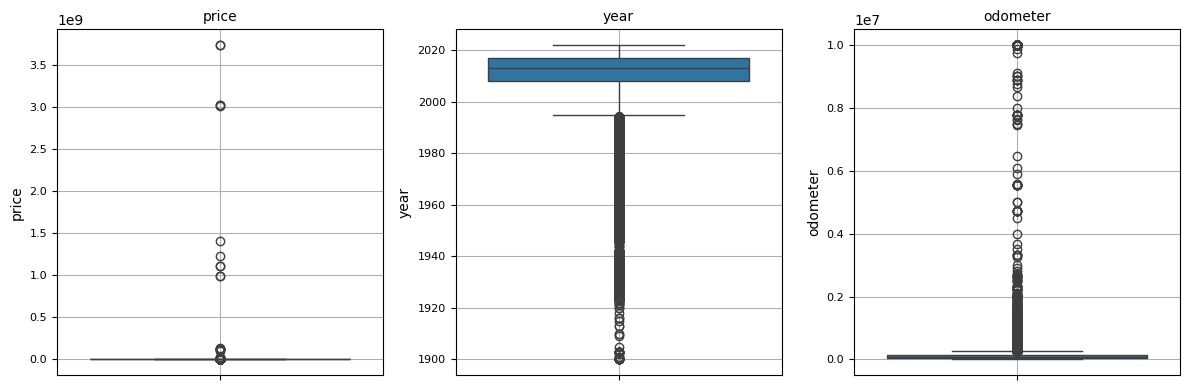

In [91]:
box_plots_2(total_data2, variables_numericas)

In [92]:
# Veamos una descripción estadistica de los campos numericos
print(total_data2.describe().round(2))

              price       year     odometer
count  4.268800e+05  425675.00    422480.00
mean   7.519903e+04    2011.24     98043.33
std    1.218228e+07       9.45    213881.50
min    0.000000e+00    1900.00         0.00
25%    5.900000e+03    2008.00     37704.00
50%    1.395000e+04    2013.00     85548.00
75%    2.648575e+04    2017.00    133542.50
max    3.736929e+09    2022.00  10000000.00


##### Antes de empezar a estudir las relaciones de **"price"** con otras variables se procedio a observar la descripción estadistica de los datos numericos.  Los Outliners y su distribución a traves de los boxplots e Histogramas.

##### De aqui podemos ver que en Price hay al menos un valor **3.736929e+09** que hay que limpiar antes de hacer estudios.
##### Eso aunado a los valores de Cero "0" que observamos previamente en el **price** serian datos que producen perturbaciones estadisticas. .

##### Se observa un Valor de 10E7 (10 millones) en 'odometer'

##### Tambíen debemos Eliminas los valores Null de los campos 'year' y 'odometer'

##### A continuacion se emplea el IQR para obtener una cota superior para 'price' y 'odometer'.  Y lo que este fuera de esas cotas sera eleiminado.

In [93]:
Outlineers_IQR(total_data2, variables_numericas)

'price': 5528 outliers detectados.  Los cuartiles son: Q1:5900.0 Q3:26485.75 . lower_bound:-24978.625 upper_bound:63540.1 
'year': 15896 outliers detectados.  Los cuartiles son: Q1:2008.0 Q3:2017.0 . lower_bound:1994.5 upper_bound:2033.2 
'odometer': 2884 outliers detectados.  Los cuartiles son: Q1:37704.0 Q3:133542.5 . lower_bound:-106053.75 upper_bound:306051.80000000005 


In [94]:
# HAgo una Copia en llamada total_data3 sobre la cual estaran los datos limpios de los Outlines de price y odometer
total_data3=total_data2.copy()
total_data3 = total_data3[(total_data3['price'] >= 500) & (total_data3['price'] <= 65000)]
total_data3 = total_data3[(total_data3['odometer'] >= 0) & (total_data3['odometer'] <= 320000)]
total_data3.shape

(375859, 22)

In [95]:
# Eliminamos los Datos Null de nuestro DataFrame
total_data3 = total_data3.dropna(subset=['price', 'odometer','year'])
total_data3.shape

(374871, 22)

#### GRAFICAS DE LOS DATOS: 'price', 'year' & 'odometer' despues de la primera limpieza de los datos:

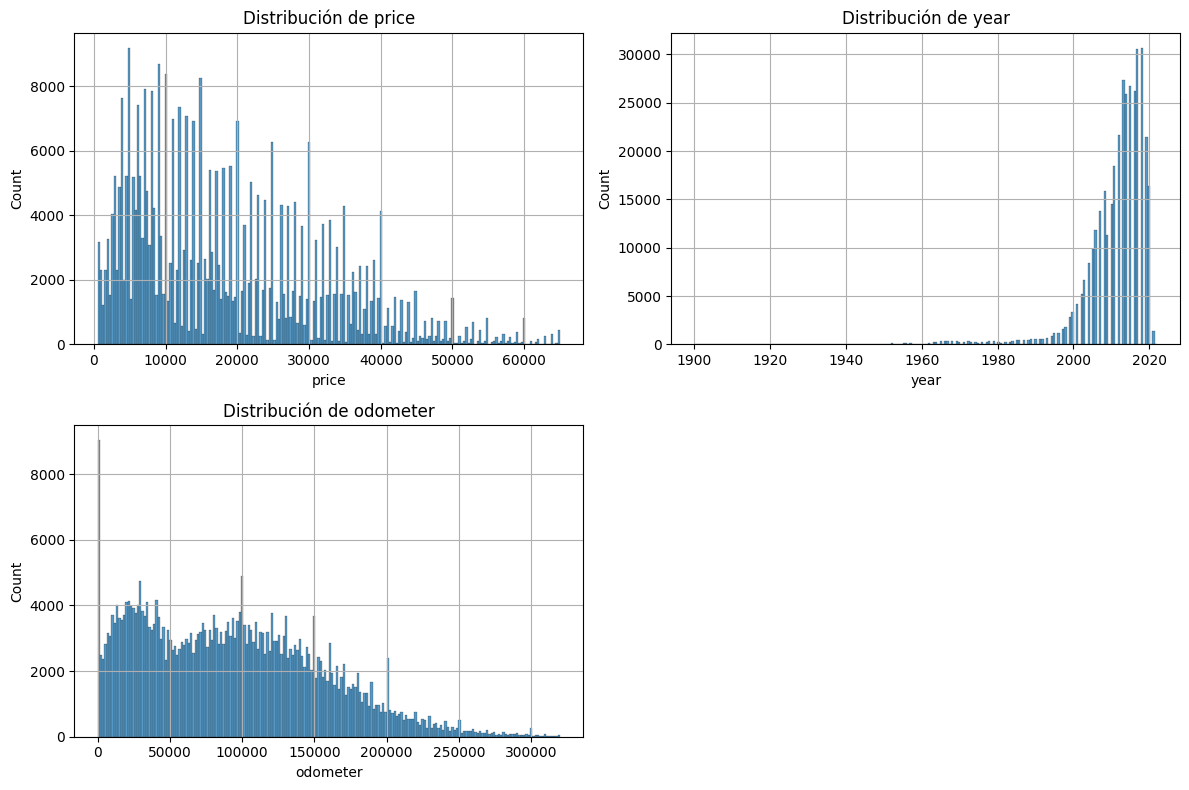

In [96]:
graficar_histogramas_autov(total_data3, variables_numericas, bins=200)

#### **price:**
- **Forma general**: claramente asimétrica positiva (sesgada a la derecha).
- **Asimetria**: 0.86, **Kurtosis**: 0.18.
- **Cola larga a la derecha**: Muchos vehículos tienen precios bajos, y pocos tienen precios muy altos.
- **Moda** en el tramo de los **5,000–15,000**.
- **No es una distribución normal**: no tiene forma de campana simétrica.
- **Picos visibles**: Posiblemente por precios comunes/redondeados (**$10,000**, **$20,000**, etc.).

---

#### **odometer:**
- **Forma general**: claramente asimétrica positiva (sesgada a la derecha).
- **Skewness**: 0.53, **Kurtosis**: -0.26.
- La mayoría de los vehículos tienen **bajo kilometraje**, y hay una “**cola**” que se extiende hacia valores más altos.
- **No es una distribución normal**: no tiene forma de campana simétrica.
- Tampoco es **lineal ni uniforme**: no hay pendiente constante ni altura pareja en la frecuencia.

---
#### **year:**
- **Forma general**: Distribución **asimétrica negativa** (sesgada a la izquierda).
- **Concentración alta** entre los años **2000 y 2023**, con un pico cerca del **año 2015–2020**.
- **Cola hacia la izquierda**: Hay algunos registros antiguos (años 1950–1990), pero muy escasos.
- **No es una Distribución normal**: No tiene simetría. Está claramente agrupada hacia años recientes.
- Podría reflejar el mercado actual de autos en venta, que naturalmente contiene **más autos modernos que antiguos**.


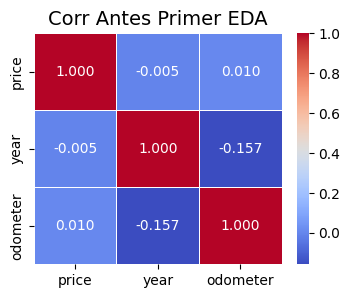

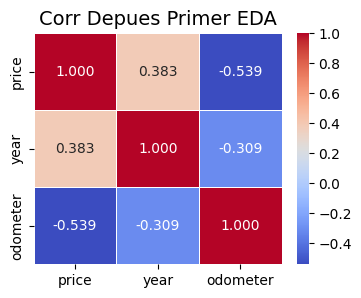

In [97]:
Graf_Corre(total_data2,variables_numericas, "Corr Antes Primer EDA")
Graf_Corre(total_data3,variables_numericas, "Corr Depues Primer EDA")

##### - price vs year (0.38)	Correlación moderada positiva: los vehículos más nuevos tienden a tener precios más altos.
##### - price vs odometer (-0.54)	Correlación moderada negativa: a mayor kilometraje, menor es el precio.

##### Sin embargo corr() me da por default la prueba de Pearson, la cual funciona bien cuando las Distribuciones son Normales y Lineales.   Pero como observamos, ninguna de las tres estadisticas estudiadas posee Distribuciones Normales.   En este caso se recomienda ver las pruebas de Spearman que es mas apropiada para otras distribuciones.

In [98]:
Prueba_de_Spearman(total_data2,'price','year', "Spearman price vs year antes de la Limpieza")
Prueba_de_Spearman(total_data3,'price','year',"Spearman price vs year despues de la Limpieza")


Spearman price vs year antes de la Limpieza 0.4914690645149488
Spearman price vs year despues de la Limpieza 0.6702608751270743


In [99]:
Prueba_de_Spearman(total_data2,'price','odometer', "Spearman price vs odometer antes de la Limpieza")
Prueba_de_Spearman(total_data3,'price','odometer', "Spearman price vs odometer despues de la Limpieza")

Spearman price vs odometer antes de la Limpieza -0.45712789041975627
Spearman price vs odometer despues de la Limpieza -0.5938930363725081


### **CONCLUSION 2:**  Las variables 'year' y 'odometer' presentan una correlación directa con 'price' que muestran resultados logicos donde a medida que el año del carro es mayor (mas Reciente), su precio aumenta (Correlación Positiva). Y cuando el valor del "odometer" aumenta el precio del carro disminuye (Correlación Negativa).  Ambas correlaciones, en especial si es estudiada bajo la "correlación de Spearman" apoyan que estas variables Sean Predictoras del Modélo.
#### Los registros despúes de la primera limpieza de Datos son 374871 y 22 Columnas (3 Numericas incluyendo el Objetivo y 19 Categóricas)

-------------------------

### **Inicio del Estudio de las variables categóricas:**
#### Procedemos a estudiar las Variables que tenemos definidas actualmente:

In [100]:
estudo_Nullidad_caracteristicas(total_data3)

📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):
 - price (374871 registros no nulos)
 - year (374871 registros no nulos)
 - odometer (374871 registros no nulos)

Total columnas numéricas: 3

🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):
 - url (374871 registros no nulos)
 - region (374871 registros no nulos)
 - region_url (374871 registros no nulos)
 - posting_date (374871 registros no nulos)
 - image_url (374871 registros no nulos)
 - state (374871 registros no nulos)
 - description (374869 registros no nulos)
 - transmission (373381 registros no nulos)
 - fuel (372769 registros no nulos)
 - model (370703 registros no nulos)
 - title_status (368507 registros no nulos)
 - manufacturer (361529 registros no nulos)
 - type (294169 registros no nulos)
 - paint_color (266409 registros no nulos)
 - drive (260339 registros no nulos)
 - condition (234736 registros no nulos)
 - VIN (230007 registros no nulos)
 - cylinders (222064 registros no nulos)

In [102]:
categorical_columns = total_data3.select_dtypes(include=['object', 'category']).columns.tolist()

for campo_cat in categorical_columns:
    print(f"{campo_cat}: {total_data3[campo_cat].nunique()} valores únicos")

url: 374871 valores únicos
region: 404 valores únicos
region_url: 413 valores únicos
manufacturer: 42 valores únicos
model: 26372 valores únicos
condition: 6 valores únicos
cylinders: 8 valores únicos
fuel: 5 valores únicos
title_status: 6 valores únicos
transmission: 3 valores únicos
VIN: 100221 valores únicos
drive: 3 valores únicos
size: 4 valores únicos
type: 13 valores únicos
paint_color: 12 valores únicos
image_url: 214140 valores únicos
description: 319605 valores únicos
state: 51 valores únicos
posting_date: 336025 valores únicos


In [104]:
total_data4=total_data3.copy()
total_data4 = total_data4.drop(columns=['url', 'region_url', 'image_url', 'VIN','description'])

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


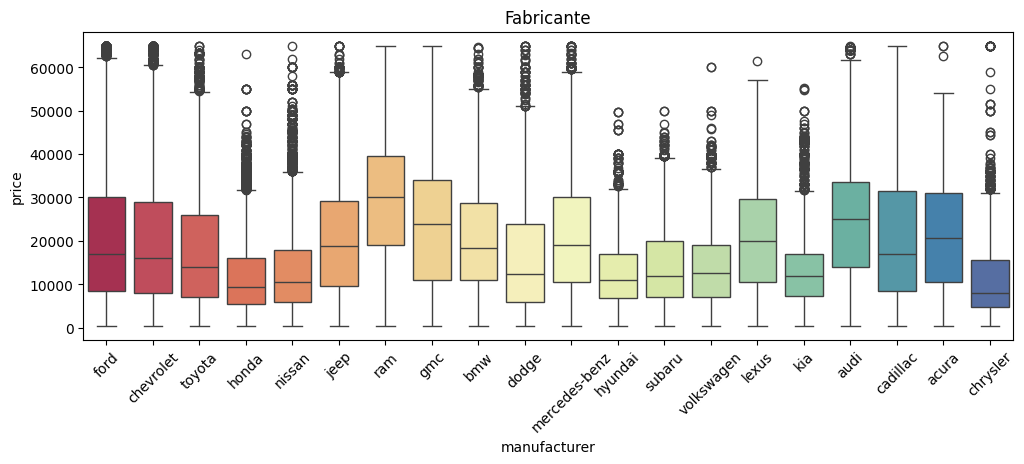

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


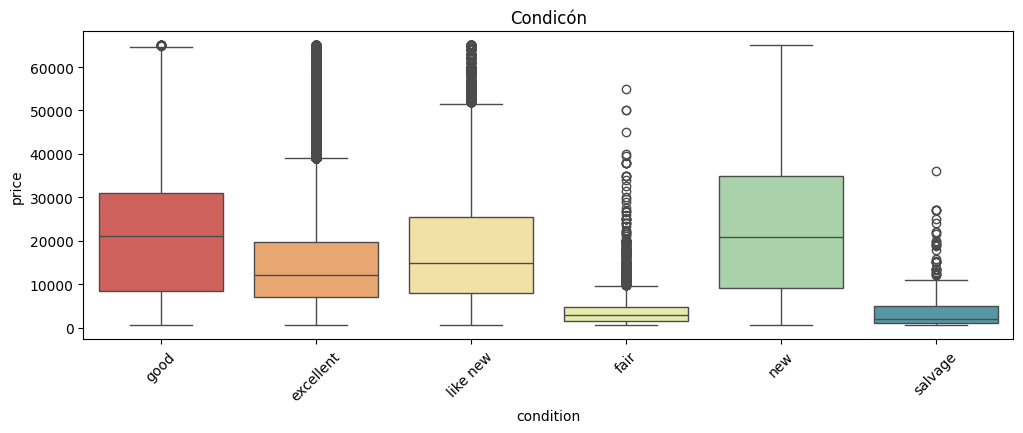

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


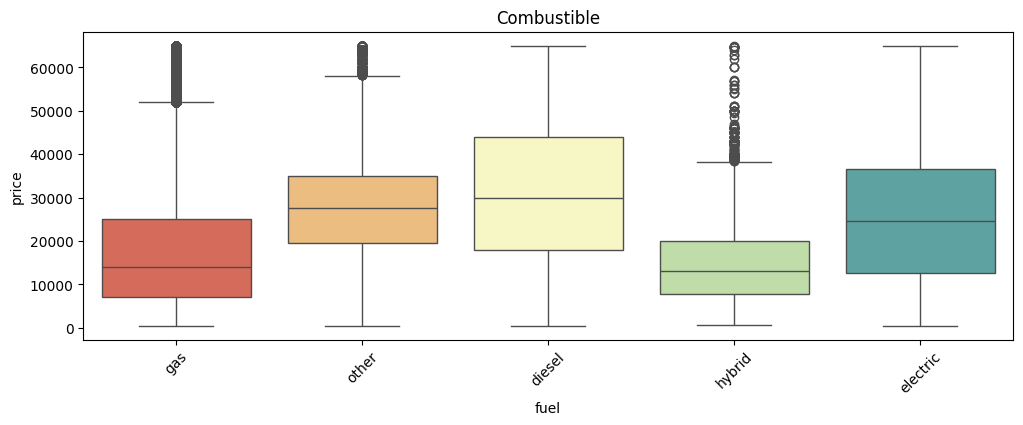

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


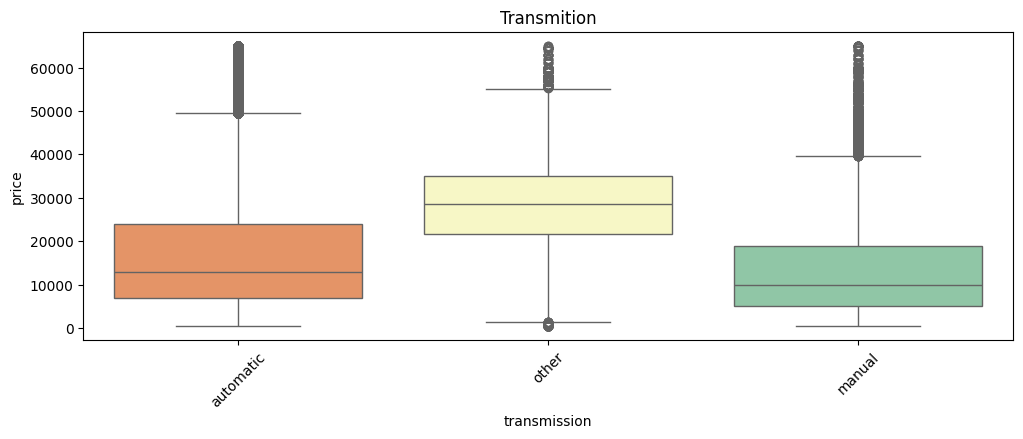

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


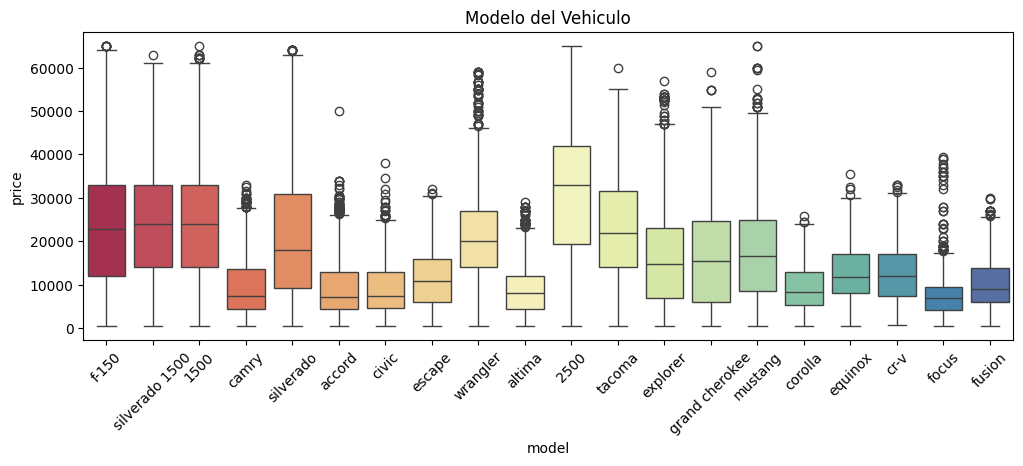

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


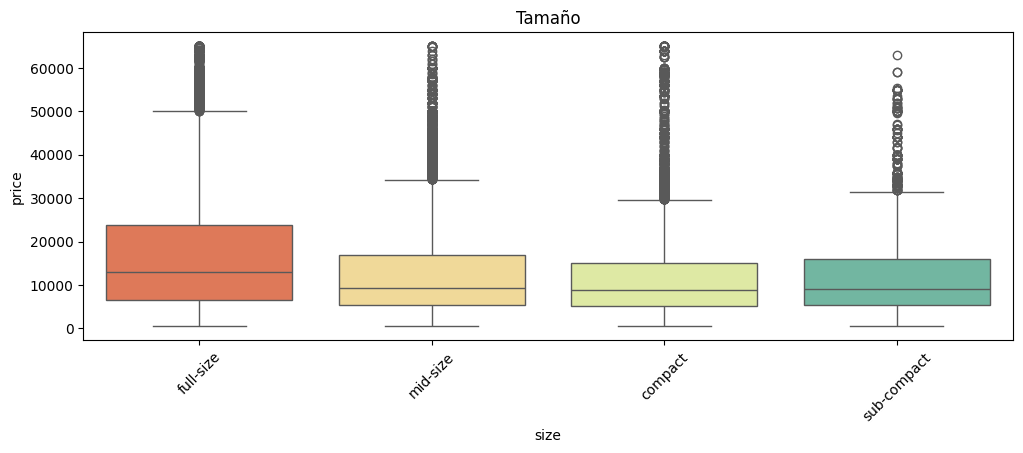

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


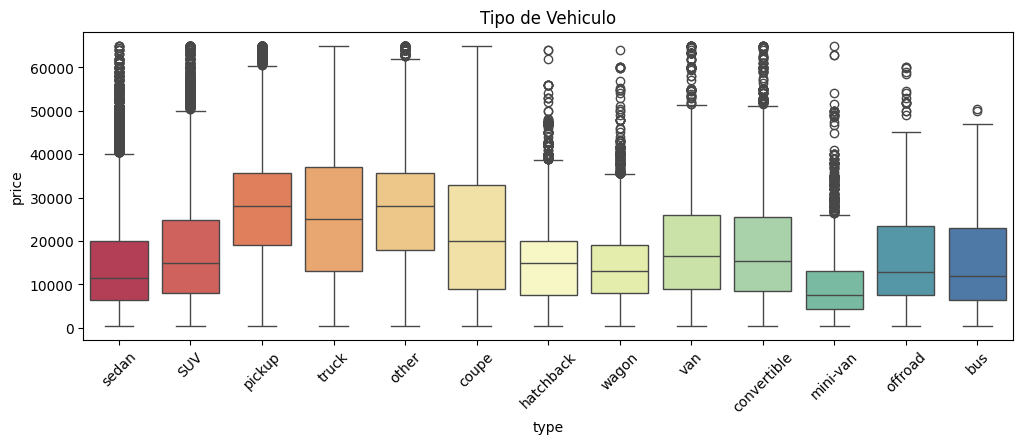

C:\Users\Pedro Caliman\AppData\Local\Temp\ipykernel_6376\3804299545.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


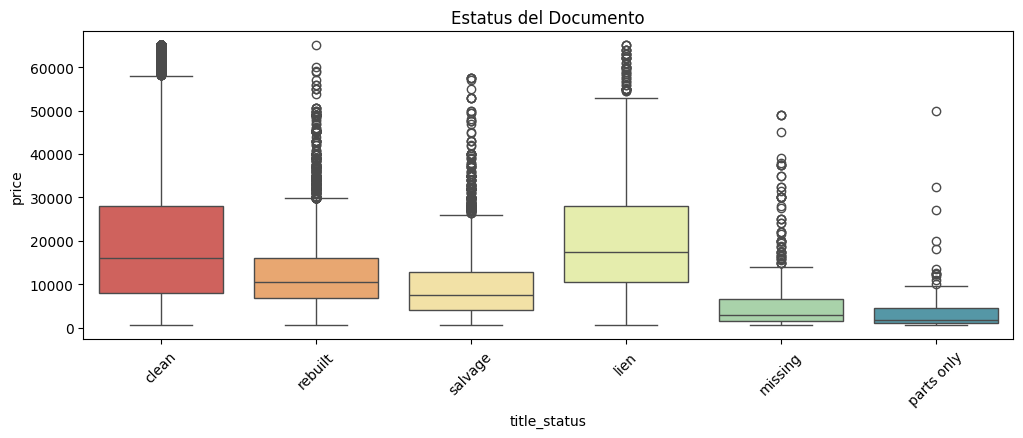

In [106]:
box_plots_3(total_data3,'manufacturer','price',"Fabricante")
box_plots_3(total_data3,'condition','price',"Condicón")
box_plots_3(total_data3,'fuel','price',"Combustible")
box_plots_3(total_data3,'transmission','price',"Transmition")
box_plots_3(total_data3,'model','price',"Modelo del Vehiculo")
box_plots_3(total_data3,'size','price',"Tamaño")
box_plots_3(total_data3,'type','price',"Tipo de Vehiculo")
box_plots_3(total_data3,'title_status','price',"Estatus del Documento")



En funcion de los Valores Null y de de los Valores unicos de los Campos: Type, paint_Color, drive, cylinders , size se pierden muchos registros. Por lo que se retiran del DataSet.


In [108]:
total_data5 = total_data4.copy()
total_data5 = total_data5.drop(columns=['paint_color', 'drive', 'cylinders', 'size','region','type'])

In [109]:
estudo_Nullidad_caracteristicas(total_data5)

📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):
 - price (374871 registros no nulos)
 - year (374871 registros no nulos)
 - odometer (374871 registros no nulos)

Total columnas numéricas: 3

🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):
 - state (374871 registros no nulos)
 - posting_date (374871 registros no nulos)
 - transmission (373381 registros no nulos)
 - fuel (372769 registros no nulos)
 - model (370703 registros no nulos)
 - title_status (368507 registros no nulos)
 - manufacturer (361529 registros no nulos)
 - condition (234736 registros no nulos)

Total columnas categóricas: 8
(374871, 11)


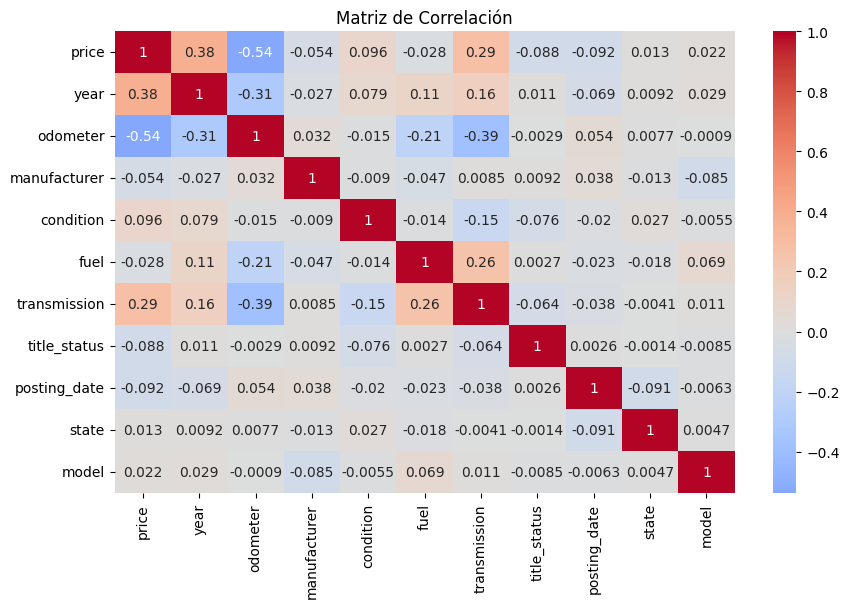

In [110]:
# Codificar variables categóricas para correlación
total_Data_numeric = total_data5.copy()
le = LabelEncoder()
categorical_cols = ['manufacturer','condition', 'fuel', 'transmission','title_status','posting_date','state','model']
for col in categorical_cols:
    total_Data_numeric[col] = le.fit_transform(total_Data_numeric[col])

plt.figure(figsize=(10, 6))
sns.heatmap(
    total_Data_numeric[['price', 'year', 'odometer', 'manufacturer','condition', 'fuel', 'transmission','title_status','posting_date','state','model']].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Matriz de Correlación')
plt.show()

In [111]:
estudo_Nullidad_caracteristicas(total_Data_numeric)

📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):
 - price (374871 registros no nulos)
 - year (374871 registros no nulos)
 - manufacturer (374871 registros no nulos)
 - model (374871 registros no nulos)
 - condition (374871 registros no nulos)
 - fuel (374871 registros no nulos)
 - odometer (374871 registros no nulos)
 - title_status (374871 registros no nulos)
 - transmission (374871 registros no nulos)
 - state (374871 registros no nulos)
 - posting_date (374871 registros no nulos)

Total columnas numéricas: 11

🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):

Total columnas categóricas: 0
(374871, 11)


In [112]:
correlation_matrix = total_Data_numeric.corr(numeric_only=True)
correlation_matrix['price'].drop('price').abs().sort_values(ascending=False).head()


odometer        0.539438
year            0.382837
transmission    0.286448
condition       0.095987
posting_date    0.091626
Name: price, dtype: float64

In [85]:
import pandas as pd
from scipy.stats import spearmanr

# Filtrar solo columnas numéricas
numeric_df = total_Data_numeric.select_dtypes(include='number')

# Crear un diccionario para almacenar las correlaciones
spearman_correlations = {}

# Calcular correlación de Spearman de cada columna contra 'price'
for col in numeric_df.columns:
    if col != 'price':
        # Filtra filas sin NaN entre price y la columna
        valid_data = numeric_df[['price', col]].dropna()
        if not valid_data.empty:
            coef, _ = spearmanr(valid_data['price'], valid_data[col])
            spearman_correlations[col] = abs(coef)  # Usamos valor absoluto para ordenar

# Ordenar por mayor correlación
sorted_corr = pd.Series(spearman_correlations).sort_values(ascending=False)

# Mostrar las 5 más correlacionadas
print(sorted_corr.head())

year            0.670261
odometer        0.593893
transmission    0.291176
condition       0.100105
posting_date    0.094586
dtype: float64
